I used the **PlantVillage Dataset** for this project, focusing on three specific categories: 'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy'. The dataset comprises grayscale images of apple leaves, each labeled according to its condition or disease, and I utilized only a subset of these categories for the analysis.

In [2]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.stats import mode, pearsonr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# dataset folder path
data_folder = "PlantVillage Dataset"

# Categories (folders for Apple dataset)
categories = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']

# lists to store images and labels
images = []
labels = []

# Iterate through each category folder
for category in categories:
    folder_path = os.path.join(data_folder, category)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    print(f"Processing folder: {category}")
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load the image
            img = Image.open(os.path.join(folder_path, filename)).convert('L')  
            img = img.resize((64, 64))  
            
            images.append(np.array(img).flatten())  
            labels.append(category)  

# Converting lists to numpy arrays
data_matrix = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(data_matrix)} images.")
print(f"Labels: {np.unique(labels)}")

Processing folder: Apple___Apple_scab
Processing folder: Apple___Black_rot
Processing folder: Apple___healthy
Loaded 1870 images.
Labels: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___healthy']


In [4]:
# Standardizing the data matrix
scaler = StandardScaler()
data_matrix_scaled = scaler.fit_transform(data_matrix)

# **A) PCA is being applied to the images from the 'PlantVillage Dataset' to determine the number of components required to preserve 90% of the variance.**

Number of components to preserve 90% variance: 140


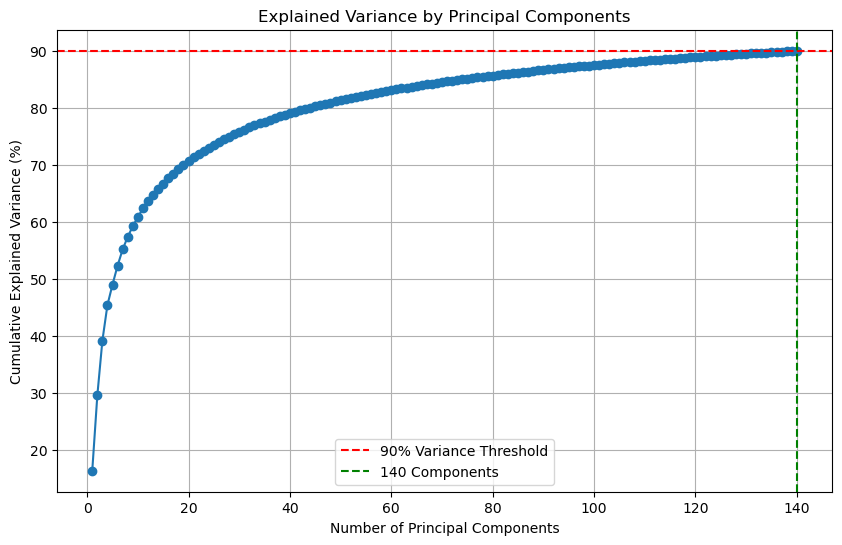

In [7]:
pca = PCA(0.90)
pca.fit(data_matrix_scaled)
n_components_90_variance = pca.n_components_
print(f"Number of components to preserve 90% variance: {n_components_90_variance}")

# Transforming data to reduced dimension
data_matrix_reduced = pca.transform(data_matrix_scaled)

# cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label="90% Variance Threshold")
plt.axvline(x=n_components_90_variance, color='g', linestyle='--', label=f"{n_components_90_variance} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid(True)
plt.show()

# **B) 10 random images from the 'PlantVillage Dataset' are being plotted in their original form (without PCA). After applying PCA to preserve 90% of the variance, the images are being reconstructed and projected back into the original space. The original images and their reconstructions are then being plotted for comparison.**

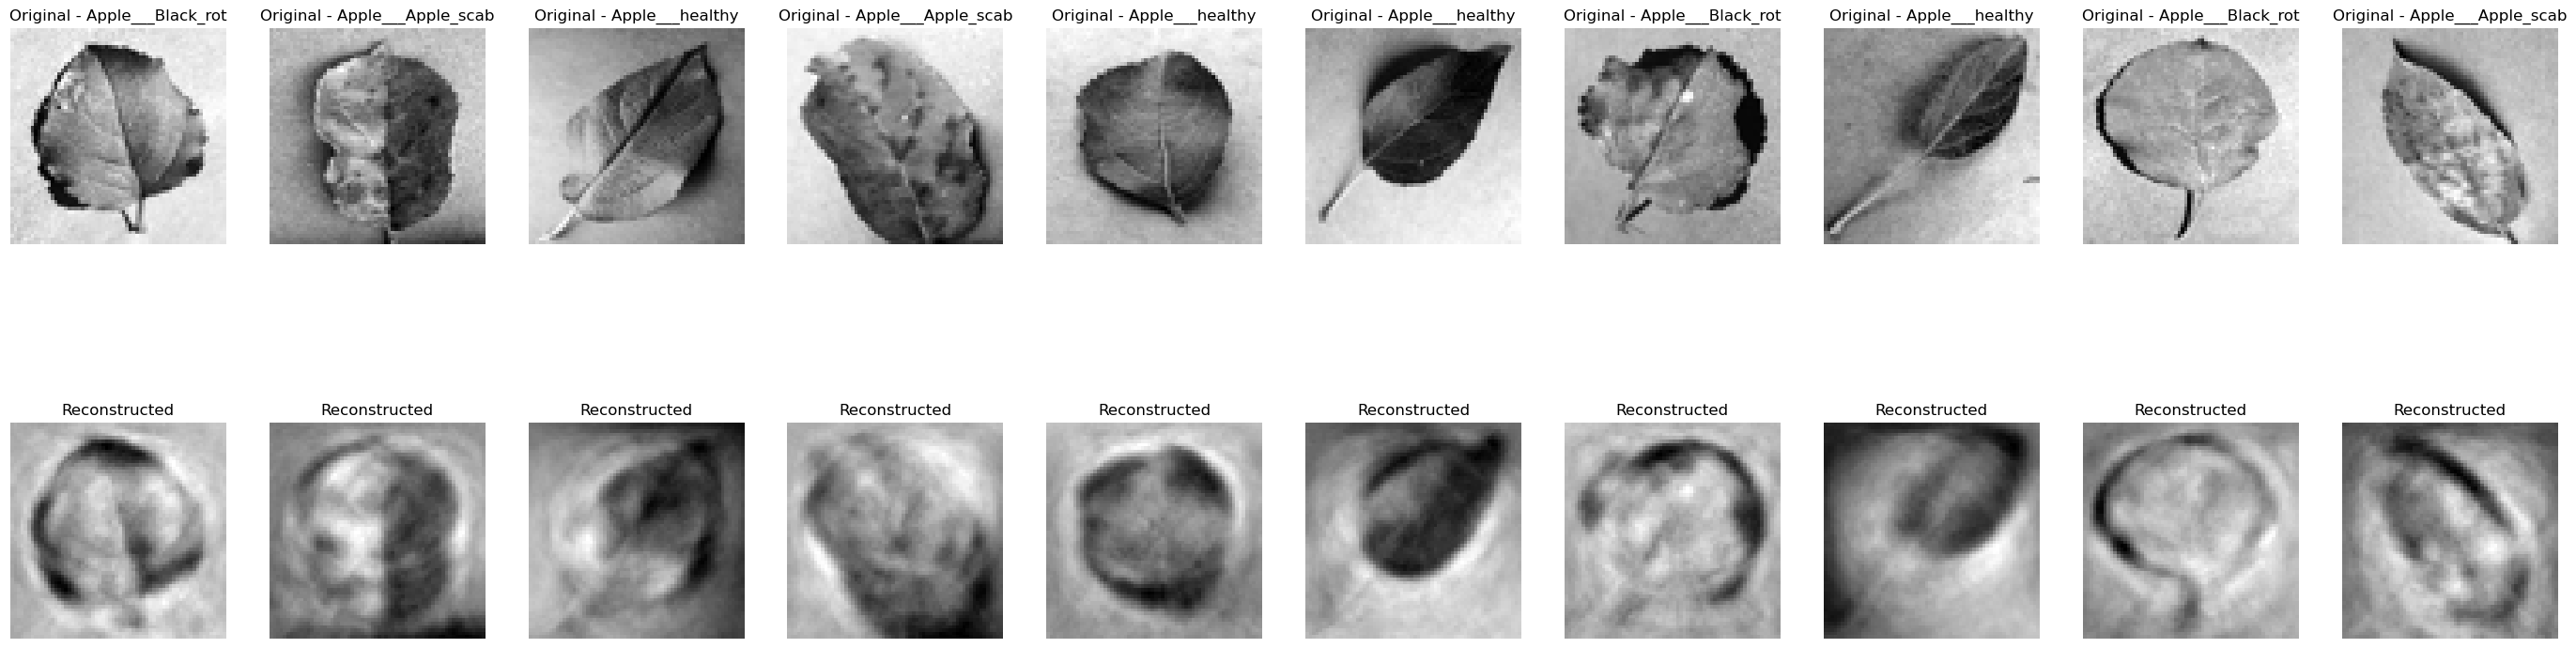

In [10]:
data_matrix_reconstructed = pca.inverse_transform(data_matrix_reduced)

# random images
num_images = 10
indices = np.random.choice(len(data_matrix), num_images, replace=False)
selected_images_original = data_matrix[indices]
selected_images_reconstructed = data_matrix_reconstructed[indices]

# original and reconstructed images
plt.figure(figsize=(35, 10))
for i in range(num_images):

    # Original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected_images_original[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title(f"Original - {labels[indices[i]]}")

    # Reconstructed
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(selected_images_reconstructed[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title("Reconstructed")
    
plt.show()

# **C) PCA is being applied to reduce the dimensionality of the data to 2D, and the variance explained by the first two principal components is being calculated. A 2D scatter plot is being created, where each image is represented by a dot, with colors corresponding to different image categories. Similar plots are being generated using t-SNE, LLE, and MDS. The observations from these plots are then being discussed to analyze the effectiveness of each dimensionality reduction technique.**

Variance explained by the first two components: 29.62%


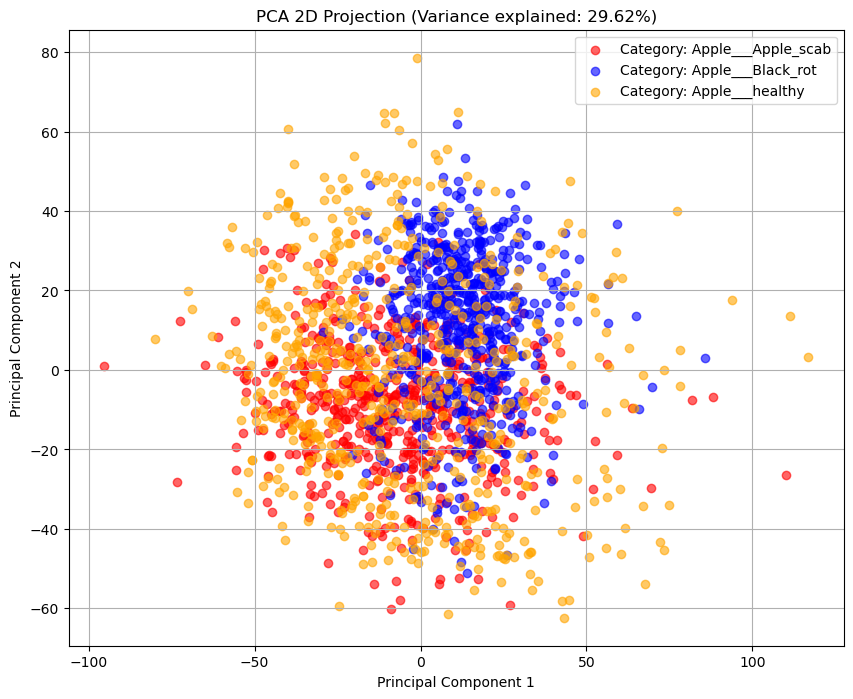

In [13]:
# PCA with 2 components
pca_2d = PCA(n_components=2)
data_matrix_2D_pca = pca_2d.fit_transform(data_matrix_scaled)
explained_variance_2d = np.sum(pca_2d.explained_variance_ratio_) * 100
print(f"Variance explained by the first two components: {explained_variance_2d:.2f}%")

# category labels and colors
categories = ['Apple___Apple_scab', 'Apple___Black_rot','Apple___healthy']
colors = {
    'Apple___Apple_scab': 'red',
    'Apple___Black_rot': 'blue',
    'Apple___healthy': 'orange'
}

# Scatter plot of the 2D PCA results
plt.figure(figsize=(10, 8))
for category in categories:
    indices = [i for i, label in enumerate(labels) if label == category]
    plt.scatter(
        data_matrix_2D_pca[indices, 0], 
        data_matrix_2D_pca[indices, 1], 
        label=f"Category: {category}", 
        color=colors[category], 
        alpha=0.6
    )

plt.title(f"PCA 2D Projection (Variance explained: {explained_variance_2d:.2f}%)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Helper function to plot with image overlays
def plot_with_images(X_2D, labels, images, title, min_distance=0.1, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X_2D)
    label_color_map = {'Apple___Apple_scab': 'red', 'Apple___Black_rot': 'blue', 'Apple___healthy': 'orange'}
    colors = [label_color_map[label] for label in labels]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=colors, alpha=0.5, edgecolor='k')

    max_images = 50  
    indices = np.random.choice(len(X_normalized), size=min(max_images, len(X_normalized)), replace=False)

    for index in indices:
        img = images[index].reshape(64, 64)
        imagebox = AnnotationBbox(OffsetImage(img, cmap="gray", zoom=0.5), X_normalized[index], frameon=False)
        ax.add_artist(imagebox)

    plt.title(title)
    plt.axis("off")
    plt.show()

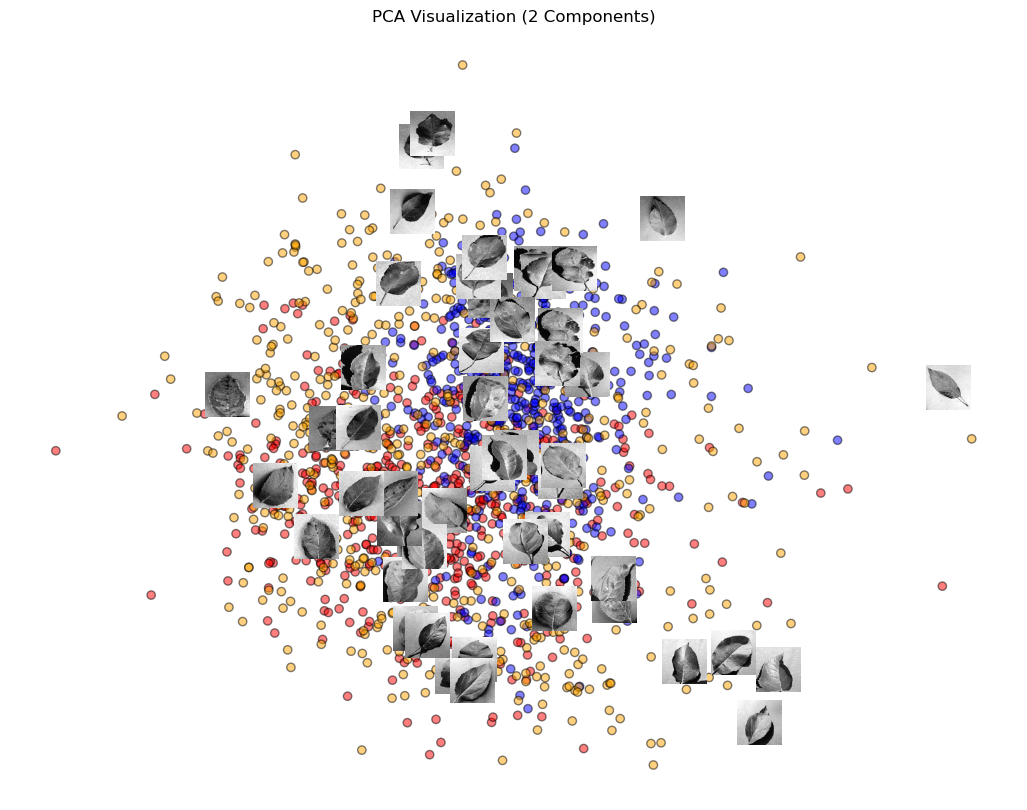

In [16]:
# PCA 2D scatter with image overlays
plot_with_images(data_matrix_2D_pca, labels, data_matrix, "PCA Visualization (2 Components)")

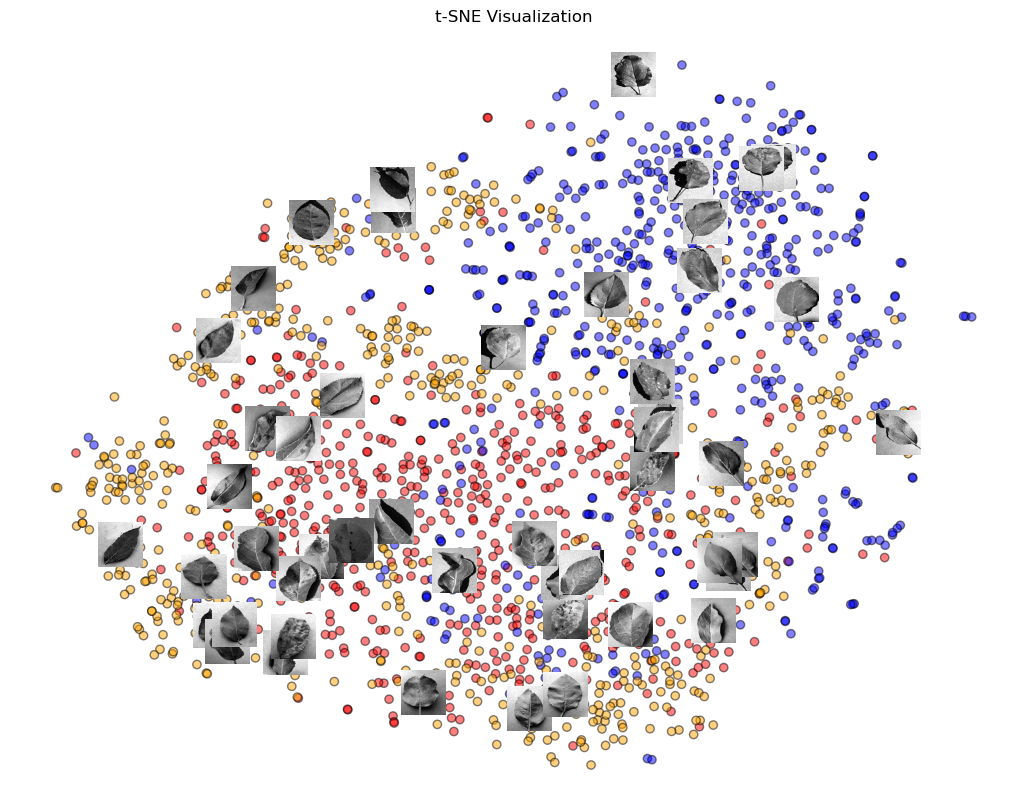

In [17]:
# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_matrix_2D_tsne = tsne.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_tsne, labels, data_matrix, "t-SNE Visualization")

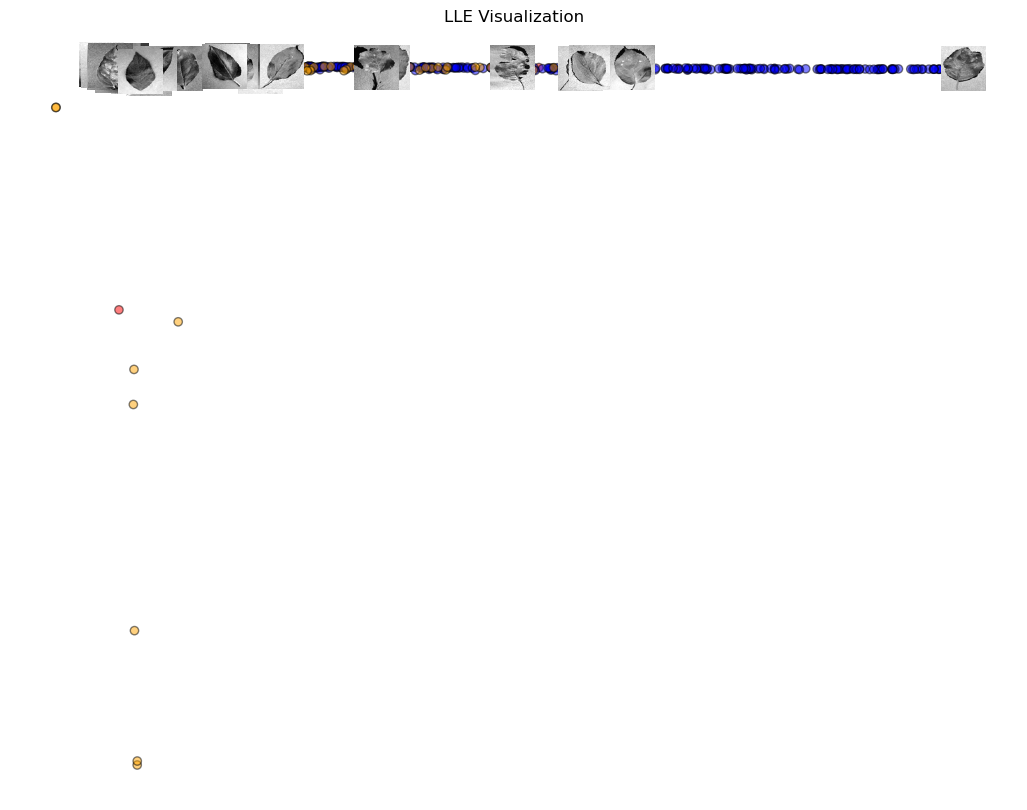

In [18]:
# LLE 2D
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
data_matrix_2D_lle = lle.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_lle, labels, data_matrix, "LLE Visualization")

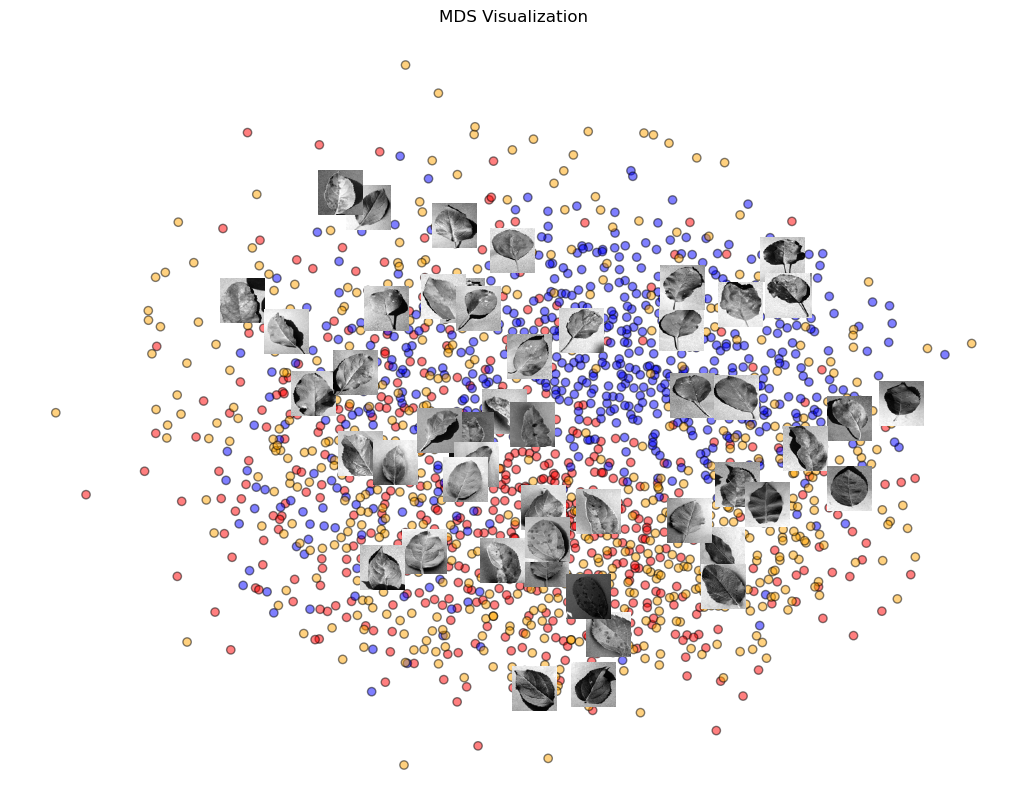

In [19]:
# MDS 2D
mds = MDS(n_components=2, random_state=42)
data_matrix_2D_mds = mds.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_mds, labels, data_matrix, "MDS Visualization")

**Discussion on the visualizations.**

**1. PCA Visualization**

The PCA plot shows leaves scattered with overlapping clusters and no clear boundaries. This means PCA captures the main patterns in the data but struggles to separate the groups. The overlap suggests some leaves are similar, making it harder to distinguish between them. Overall, PCA gives a general view of the data but may miss more complex relationships.

**2. t-SNE Visualization**

The t-SNE plot clearly groups data points into distinct clusters, making it easy to identify different classes. This shows that t-SNE effectively captures both local and global structures in the dataset, making it ideal for visualizing high-dimensional data. The separation between clusters highlights the algorithm's ability to reveal meaningful patterns.

**3. LLE (Locally Linear Embedding) Visualization**

The LLE plot shows most data points packed into a narrow line with minimal spread, making it difficult to identify distinct groups. This suggests that LLE struggles to represent this dataset in 2D, likely due to its focus on preserving only local relationships, which might not be enough for complex structures like this.

**4. MDS (Multi-Dimensional Scaling) Visualization**

The MDS plot spreads the data points more evenly across the space, showing some clusters and groupings. However, there’s noticeable overlap between classes, indicating that MDS preserves distances reasonably well but fails to capture more complex or non-linear patterns in the dataset.

# **D) The images are being clustered using K-Means, with dimensionality reduction applied through PCA to retain at least 90% of the variance. The number of clusters is determined using an appropriate technique, and the number of clusters is set to 3. The clustering accuracy is then reported.**

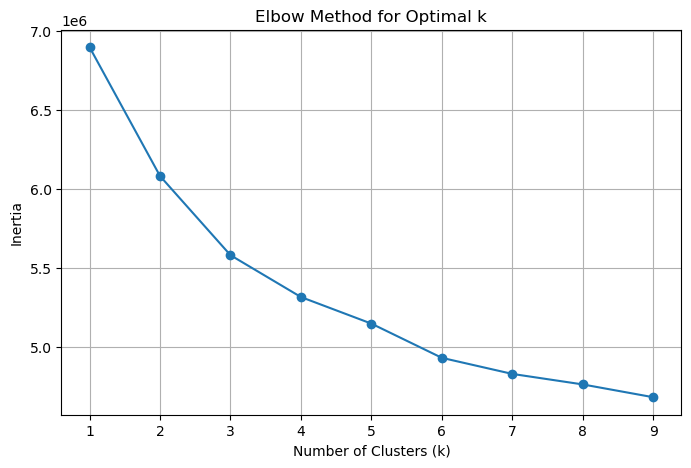

In [23]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_matrix_reduced)
    inertia.append(kmeans.inertia_)

# Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

**The elbow appears around k = 3 clusters. Therefore, 3 clusters is the optimal choice based on this method.**

In [26]:
# K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(data_matrix_reduced)

label_mapping = {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___healthy':2}
true_labels = np.array([label_mapping[label] for label in labels])

# Mapping each cluster label to true label using majority voting
mapped_labels_kmeans = np.zeros_like(cluster_labels_kmeans)
for i in range(3):
    mask = (cluster_labels_kmeans == i)
    mapped_labels_kmeans[mask] = mode(true_labels[mask])[0]

# accuracy
accuracy_kmeans = accuracy_score(true_labels, mapped_labels_kmeans)
print(f"K-Means Clustering Accuracy with k=3: {accuracy_kmeans * 100:.2f}%")

K-Means Clustering Accuracy with k=3: 52.62%


# **E) The images are being clustered using the Expectation-Maximization (EM) algorithm, with dimensionality reduction applied through PCA to retain at least 90% of the variance. The number of clusters is determined using an appropriate technique, and the number of clusters is set to 3. The clustering accuracy is then reported. Additionally, the model is being used to generate 20 new rocks using the sample() method, and these generated images are visualized in the original image space using the inverse_transform() method.**

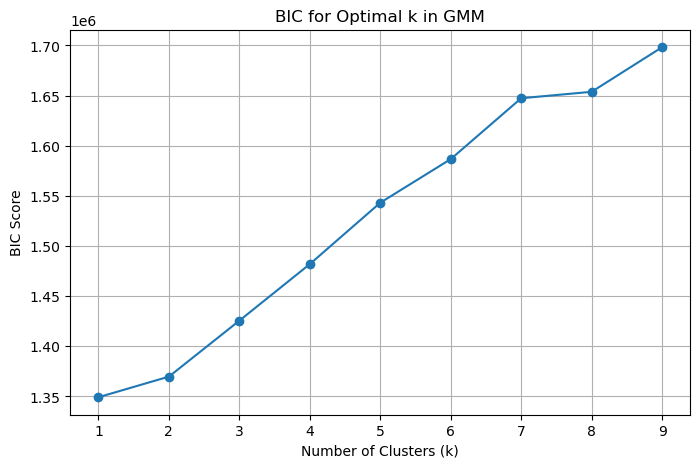

In [29]:
bic_scores = []
K_range = range(1, 10)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)
    bic_scores.append(gmm.bic(data_matrix_reduced))

# BIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("BIC for Optimal k in GMM")
plt.grid(True)
plt.show()

**From the plot, the lowest BIC score is at k = 1 cluster. Hence, 1 cluster is the optimal choice according to this method.**

**This behavior indicates that BIC favors simpler models (with fewer clusters) and penalizes complexity more heavily than AIC.**

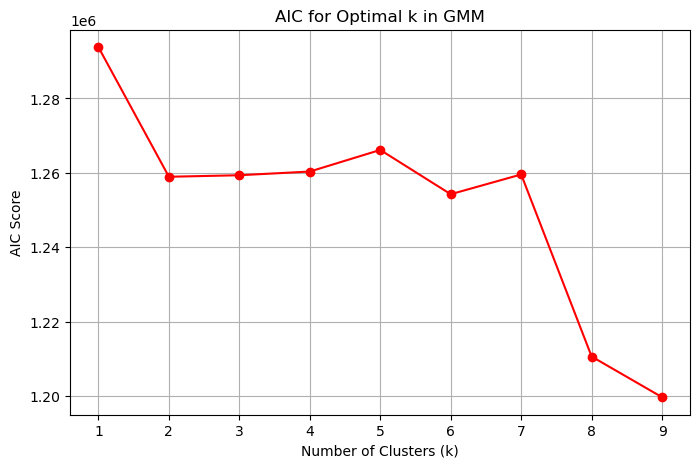

In [31]:
aic_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)  
    aic_scores.append(gmm.aic(data_matrix_reduced))  

# AIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, aic_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("AIC Score")
plt.title("AIC for Optimal k in GMM")
plt.grid(True)
plt.show()

**AIC is minimized when the number of clusters (k) is 9**

**AIC prefers models with higher complexity since it does not penalize additional parameters as strongly as BIC.**

In [34]:
# Fit GMM with k=3
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(data_matrix_reduced)

# Mapping GMM cluster labels to true labels using majority voting
mapped_labels_gmm = np.zeros_like(gmm_labels)
for i in range(3):
    mask = (gmm_labels == i)
    mapped_labels_gmm[mask] = mode(true_labels[mask])[0]

# accuracy
accuracy_gmm = accuracy_score(true_labels, mapped_labels_gmm)
print(f"GMM Clustering Accuracy with k=3: {accuracy_gmm * 100:.2f}%")

GMM Clustering Accuracy with k=3: 55.99%


Shape of new_samples_original: (20, 4096)


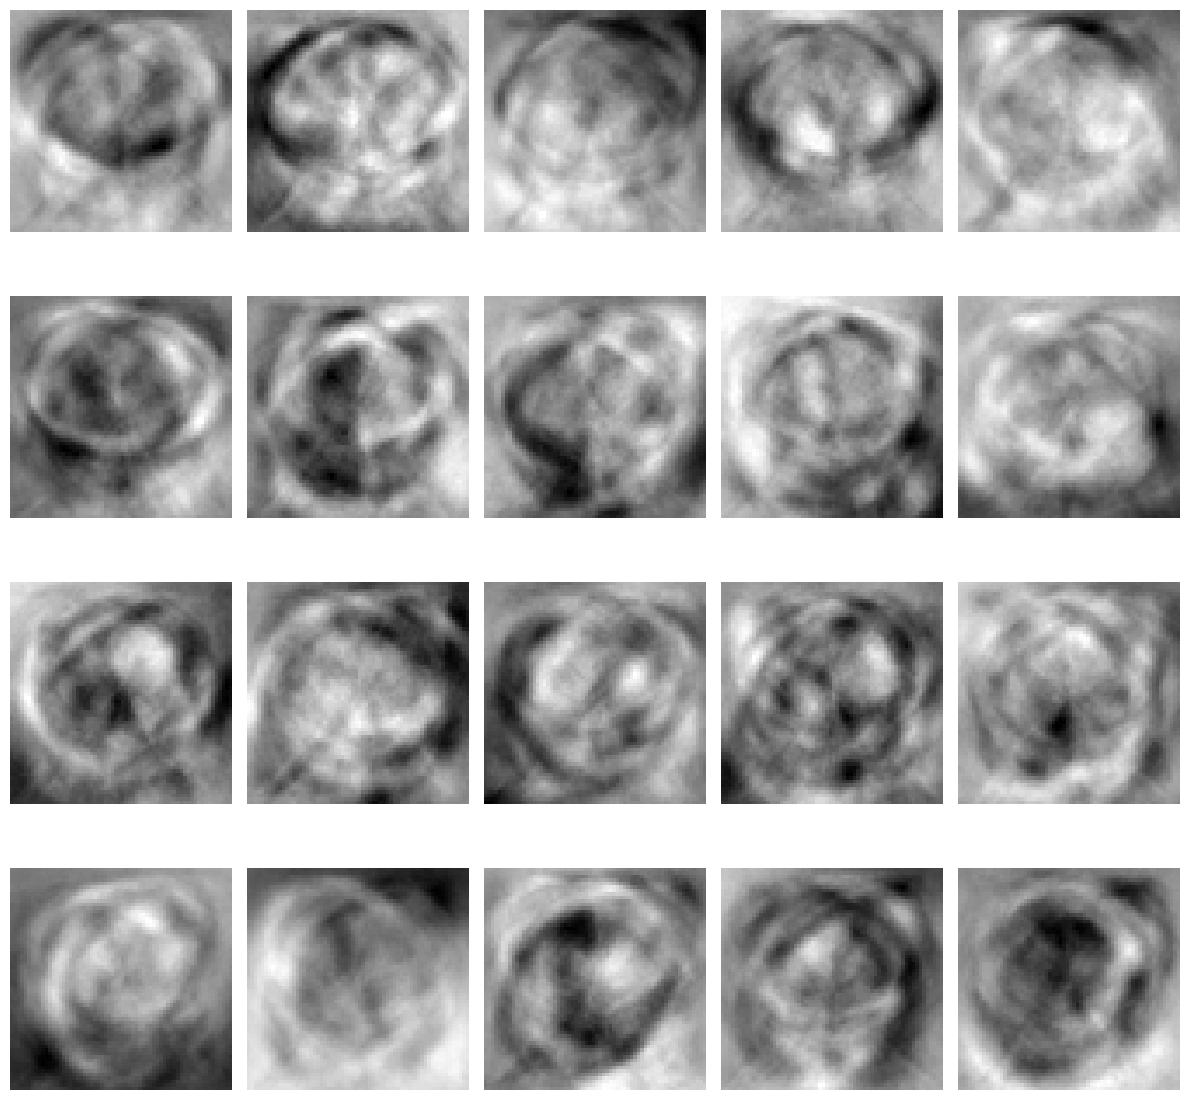

In [36]:
# 20 new samples using the GMM model
num_samples = 20
new_samples_reduced, _ = gmm.sample(num_samples) 

# Inverse transform the reduced samples back to the original image space
new_samples_original = pca.inverse_transform(new_samples_reduced)

print(f"Shape of new_samples_original: {new_samples_original.shape}")

# Visualizing the 20 new "rocks"
fig, axes = plt.subplots(4, 5, figsize=(12, 12))  
axes = axes.flatten()

for i in range(num_samples):
    axes[i].imshow(new_samples_original[i].reshape(64, 64), cmap='gray')  
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

# **F) A feedforward neural network is built using Keras (within TensorFlow) or PyTorch, with a few hidden layers and an output layer consisting of 8 neurons before the softmax activation. The hidden layers use the ReLU activation function. The network is trained for multiple epochs until convergence, with the training time reported using code. Training and validation loss, along with accuracy, are plotted as a function of training epochs. The total number of parameters in the network is calculated, and the number of bias parameters is determined.**

In [38]:
# Encoding labels and splitting data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels) 
one_hot_labels = to_categorical(encoded_labels)  

train_images, val_images, train_labels, val_labels = train_test_split(data_matrix_scaled, one_hot_labels, test_size=0.2, random_state=42, stratify = encoded_labels)

# Reshaping the data to match the input shape expected by the model
train_images = train_images.reshape(-1, 64, 64, 1)
val_images = val_images.reshape(-1, 64, 64, 1)

print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

Training images: (1496, 64, 64, 1)
Validation images: (374, 64, 64, 1)
Number of classes: 3


In [40]:
# input shape and number of classes
input_shape = (64, 64, 1)
num_classes = len(label_encoder.classes_)

inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(8, activation='relu')(x)  
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

# Early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = time.time()
history = model.fit(
    train_images, 
    train_labels, 
    epochs=30, 
    batch_size=32, 
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping] 
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time with Early Stopping: {training_time:.2f} seconds")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 691,427 (2.64 MB)

 Trainable params: 691,427 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.3406 - loss: 1.1086 - val_accuracy: 0.4011 - val_loss: 1.0640
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5504 - loss: 0.9055 - val_accuracy: 0.7647 - val_loss: 0.6398
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7738 - loss: 0.5389 - val_accuracy: 0.7219 - val_loss: 0.6325
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8358 - loss: 0.4437 - val_accuracy: 0.8021 - val_loss: 0.5113
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8730 - loss: 0.3253 - val_accuracy: 0.8583 - val_loss: 0.3778
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9288 - loss: 0.2287 - val_accuracy: 0.8743 - val_loss: 0.3324
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9533 - loss: 0.1353 - val_accuracy: 0.8850 - val_loss: 0.3225
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9671 - loss: 0.1054 - val_accuracy: 0.8824 - v

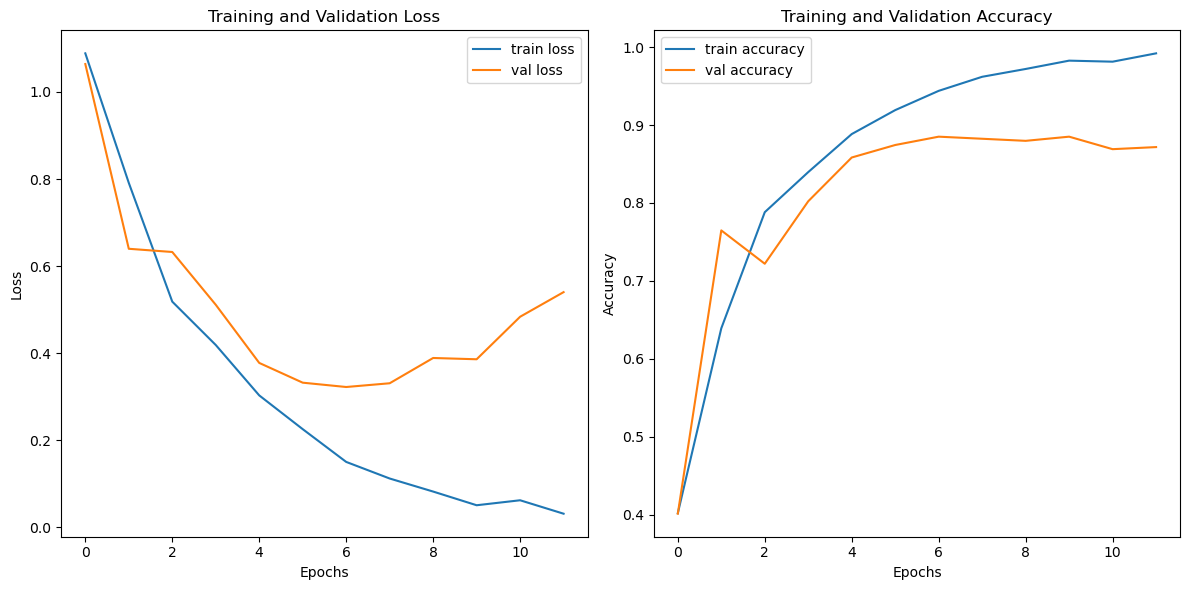

In [41]:
# training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [43]:
# total number of parameters
total_params = model.count_params()

# bias parameters
bias_params = sum(np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name)

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")

Total parameters: 691427
Bias parameters: 427
